<a href="https://colab.research.google.com/github/Ibrahim-Ezmazy/python-Projects/blob/main/Proposed_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install necessary libraries
!pip install kaggle

# Kaggle API key authentication
from google.colab import files
files.upload()

# Create a kaggle directory and move kaggle.json there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

# Download and extract the dataset
!kaggle datasets download -d buraktaci/multiple-sclerosis
import zipfile
with zipfile.ZipFile('multiple-sclerosis.zip', 'r') as zip_ref:
    zip_ref.extractall('ms_dataset')


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/buraktaci/multiple-sclerosis
License(s): unknown
100% 628M/630M [00:33<00:00, 25.2MB/s]
100% 630M/630M [00:33<00:00, 19.6MB/s]


In [3]:
trainpath='/kaggle/input/intel-image-classification/seg_train'

In [4]:
import os
import glob as gb

# Specify the base directory path
base_path = '/content/ms_dataset'

# Construct the full path to the 'seg_train' directory
train_path = os.path.join(base_path, 'Multiple Sclerosis') # added space in folder name

# Get the list of folders in the 'seg_train' directory
folders = os.listdir(train_path)

# Iterate over the folders
for folder in folders:
    # Construct the full path to the current folder
    folder_path = os.path.join(train_path, folder)

    # Get the list of files in the current folder
    files = gb.glob(os.path.join(folder_path, '*.png'))

    # Print the number of files found in the current folder
    print(f"For training data, found {len(files)} in folder {folder}")

For training data, found 761 in folder MS-Sagittal
For training data, found 1014 in folder Control-Sagittal
For training data, found 1002 in folder Control-Axial
For training data, found 650 in folder MS-Axial


In [5]:
import matplotlib.pyplot as plt
import pandas as pd

size = []
for folder in folders:
    # Construct the full path to the current folder
    folder_path = os.path.join(train_path, folder)
    # Get the list of files in the current folder
    files = gb.glob(os.path.join(folder_path, '*.png'))
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

,count
"(569, 1158, 4)",2764
"(638, 1222, 4)",425
"(628, 1158, 4)",170
"(695, 1222, 4)",46
"(661, 1493, 4)",14
"(618, 758, 4)",2
"(719, 1493, 4)",2
"(687, 912, 4)",1
"(515, 450, 4)",1
"(606, 722, 4)",1


In [6]:
code ={'Control-Axial':0,'Control-Sagittal':1,'MS-Axial':2,'MS-Sagittal':3}

def get_code(n) :
    for x , y in code.items():
        if n==y :
            return x

In [7]:
import cv2
s=150

In [8]:
x_train= []
y_train= []
for folder in folders:
    # Construct the full path to the current folder
    folder_path = os.path.join(train_path, folder)
    # Get the list of files in the current folder
    files = gb.glob(os.path.join(folder_path, '*.png'))
    for file in files:
        image =cv2.imread(file)
        image_array = cv2.resize(image , (s,s))
        x_train.append(list(image_array))
        y_train.append(code[folder])

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, VGG16, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np


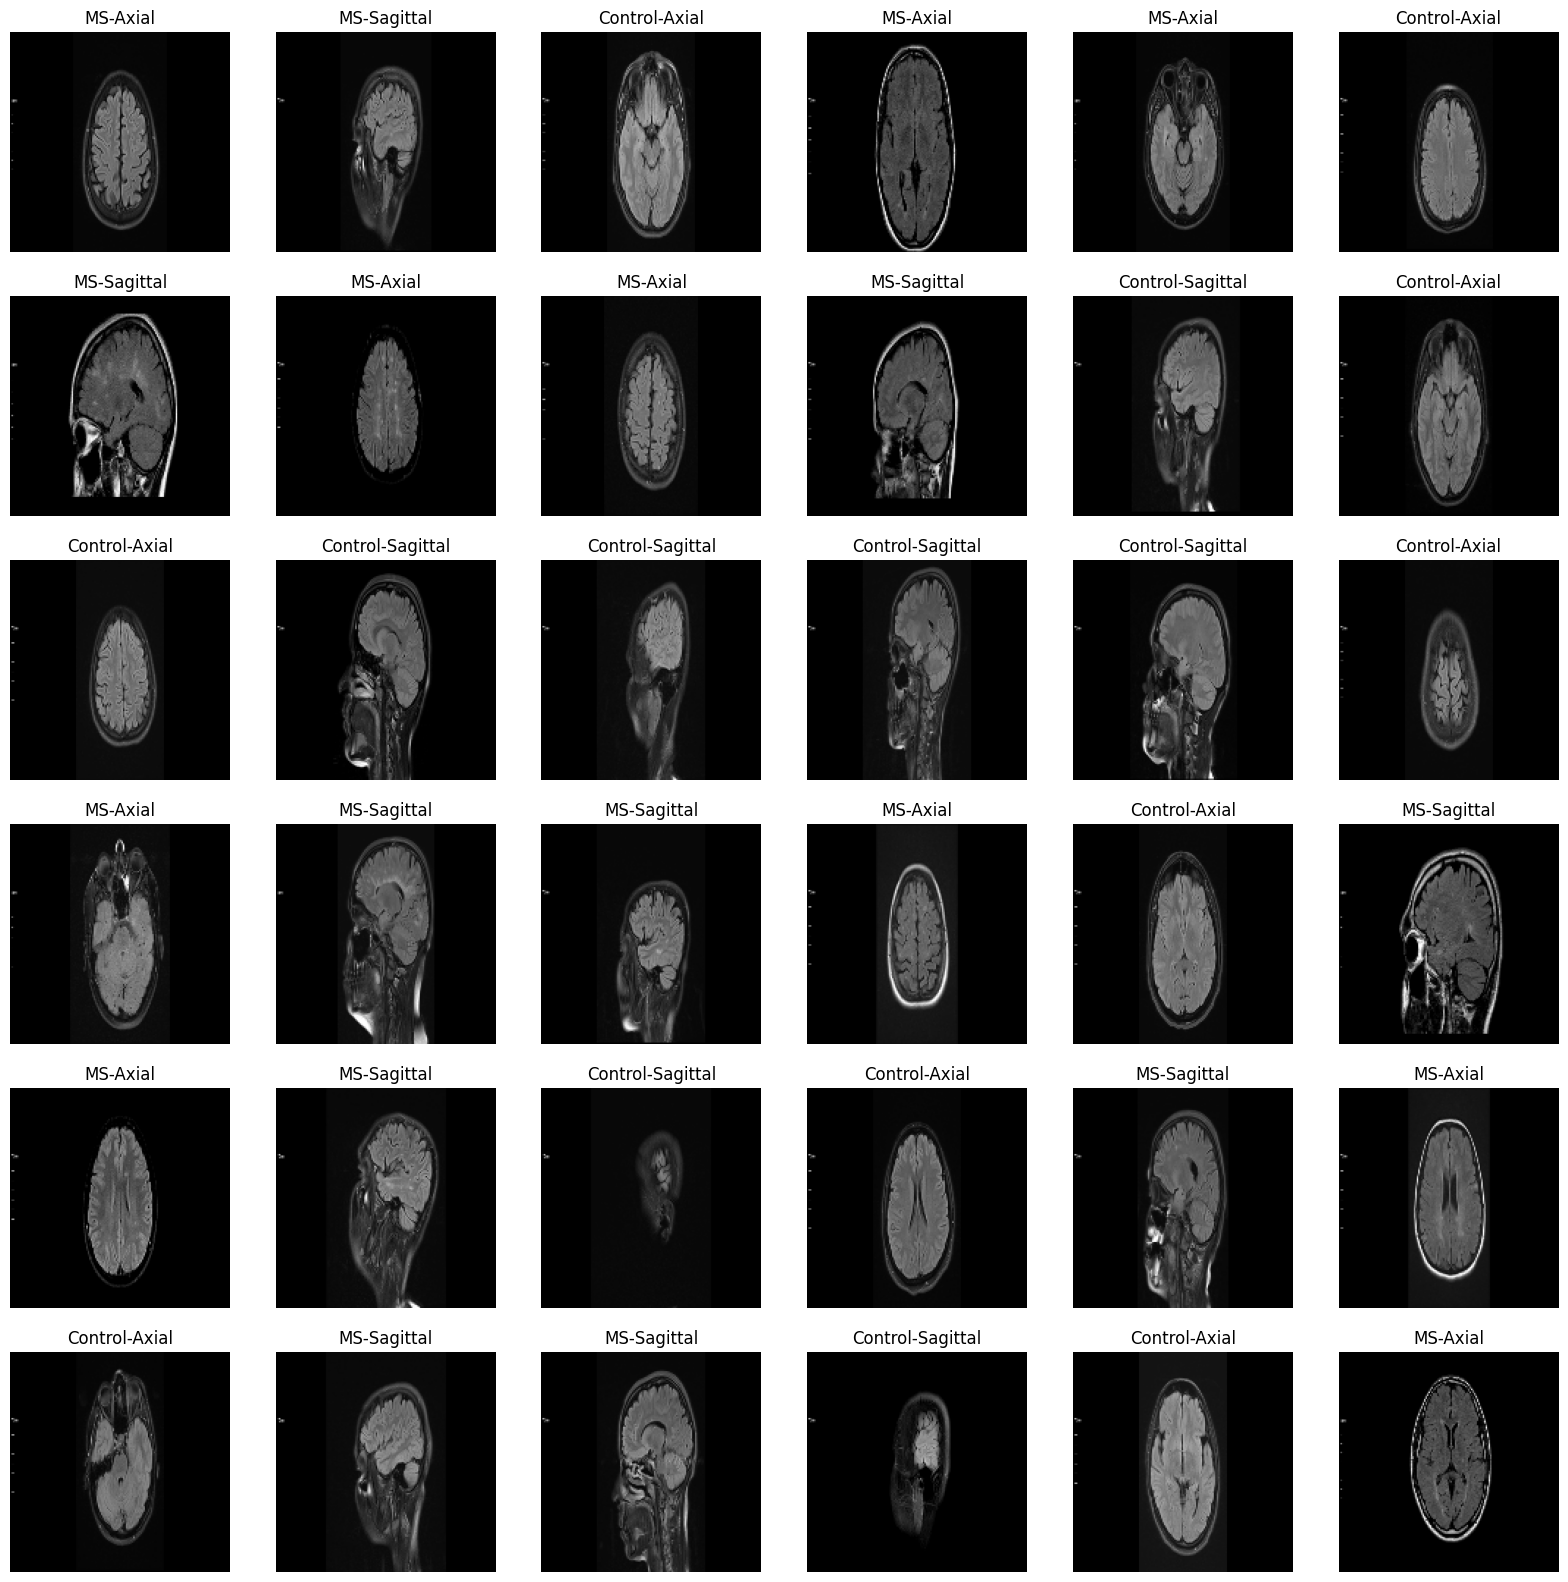

In [10]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_train),36))):
    plt.subplot(6,6,n+1)
    plt.imshow(x_train[i])
    plt.axis('Off')
    plt.title(get_code(y_train[i]))

In [11]:
x_train = np.array(x_train)
y_train = np.array(y_train)
print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')

x_train shape is (3427, 150, 150, 3)
y_train shape is (3427,)


In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
x_train, x_val_test, y_train, y_val_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42)

# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# Number of classes
num_classes = 4

In [13]:
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_classes)
y_val_encoded = to_categorical(y_val, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)


In [14]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(s, s, 3)))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)
googlenet_model = Model(inputs=base_model.input, outputs=output)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [15]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(s, s, 3))
resnet_x = resnet_base.output
resnet_x = GlobalAveragePooling2D()(resnet_x)
resnet_x = Dense(1024, activation='relu')(resnet_x)
resnet_output = Dense(num_classes, activation='softmax')(resnet_x)
resnet_model = Model(inputs=resnet_base.input, outputs=resnet_output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [16]:
googlenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
googlenet_history = googlenet_model.fit(x_train, y_train_encoded, validation_data=(x_val, y_val_encoded), epochs=10, batch_size=32)


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 644s 7s/step - accuracy: 0.7269 - loss: 0.8255 - val_accuracy: 0.5685 - val_loss: 1.6936
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 594s 7s/step - accuracy: 0.8752 - loss: 0.3173 - val_accuracy: 0.5714 - val_loss: 18.0635
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 616s 7s/step - accuracy: 0.9206 - loss: 0.2082 - val_accuracy: 0.7609 - val_loss: 0.8122
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 616s 7s/step - accuracy: 0.9546 - loss: 0.1338 - val_accuracy: 0.8426 - val_loss: 0.5972
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 625s 7s/step - accuracy: 0.9577 - loss: 0.1136 - val_accuracy: 0.9125 - val_loss: 0.2791
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 621s 7s/step - accuracy: 0.9603 - loss: 0.1028 - val_accuracy: 0.4140 - val_loss: 3.0980
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 579s 7s/step - accuracy: 0.9619 - loss: 0.1130 - val_accuracy: 0.8630 - val_loss: 0.8205
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 583s 7s/step - accuracy: 0.9594 - loss: 0.1207 - val_accuracy: 0.8776 - 

In [18]:
resnet_history = resnet_model.fit(x_train, y_train_encoded, validation_data=(x_val, y_val_encoded), epochs=10, batch_size=32)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1146s 13s/step - accuracy: 0.6956 - loss: 0.9599 - val_accuracy: 0.2624 - val_loss: 128.4308
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1088s 13s/step - accuracy: 0.8859 - loss: 0.3024 - val_accuracy: 0.3149 - val_loss: 1.6008
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1088s 13s/step - accuracy: 0.9272 - loss: 0.1986 - val_accuracy: 0.3149 - val_loss: 1.4584
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1084s 13s/step - accuracy: 0.9426 - loss: 0.1545 - val_accuracy: 0.3149 - val_loss: 1.4011
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1112s 13s/step - accuracy: 0.9509 - loss: 0.1187 - val_accuracy: 0.2187 - val_loss: 1.4854
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1079s 13s/step - accuracy: 0.9693 - loss: 0.0813 - val_accuracy: 0.3149 - val_loss: 1.3739
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1119s 13s/step - accuracy: 0.9573 - loss: 0.1233 - val_accuracy: 0.2682 - val_loss: 1.7023
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1094s 13s/step - accuracy: 0.9778 - loss: 0.0576 - val_ac

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Assuming you have trained models: googlenet_model, resnet_model

googlenet_preds = googlenet_model.predict(x_test)

resnet_preds = resnet_model.predict(x_test)

combined_preds = np.hstack([googlenet_preds, resnet_preds])

# Fit a meta-classifier (e.g., Logistic Regression)
meta_classifier = LogisticRegression()
print(f"Shape of y_test: {y_test_encoded.shape}")
meta_classifier.fit(combined_preds, np.argmax(y_test_encoded, axis=1))

final_preds = meta_classifier.predict(combined_preds)

# Evaluate the final predictions
print(classification_report(np.argmax(y_test_encoded, axis=1), final_preds))
roc_score = roc_auc_score(y_test_encoded, meta_classifier.predict_proba(combined_preds), average='weighted')
print(f'ROC AUC Score: {roc_score}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step
Shape of y_test: (343, 4)
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       101
           1       0.99      0.94      0.97       103
           2       0.85      0.84      0.85        56
           3       0.92      0.99      0.95        83

    accuracy                           0.93       343
   macro avg       0.92      0.92      0.92       343
weighted avg       0.93      0.93      0.93       343

ROC AUC Score: 0.993056361248684


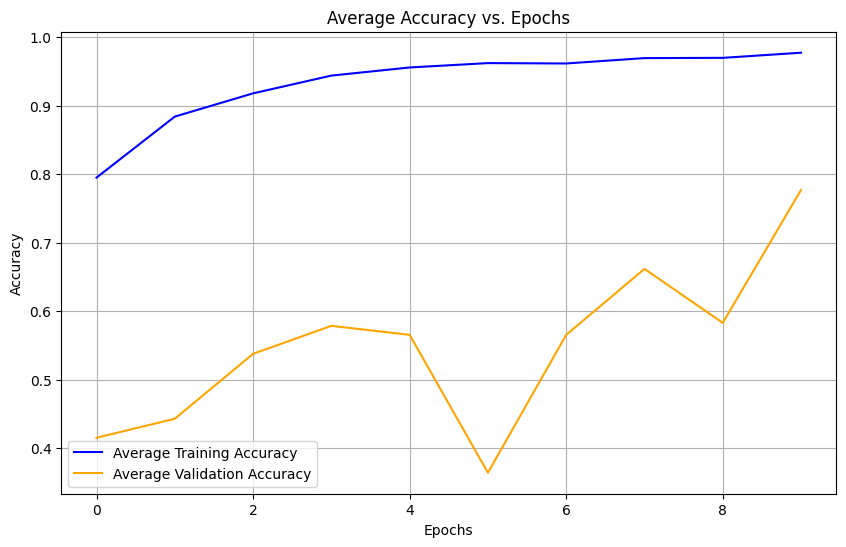

In [24]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(len(googlenet_history.history['accuracy']))

# Calculate the average training accuracy and validation accuracy
avg_train_acc = np.mean(
    [googlenet_history.history['accuracy'],

     resnet_history.history['accuracy']],
    axis=0)

avg_val_acc = np.mean(
    [googlenet_history.history['val_accuracy'],

     resnet_history.history['val_accuracy']],
    axis=0)

# Plotting the accuracy curves
plt.figure(figsize=(10, 6))

# Plot for Training Accuracy (averaged)
plt.plot(epochs, avg_train_acc, label='Average Training Accuracy', color='blue')

# Plot for Validation Accuracy (averaged)
plt.plot(epochs, avg_val_acc, label='Average Validation Accuracy', color='orange')

plt.title('Average Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step


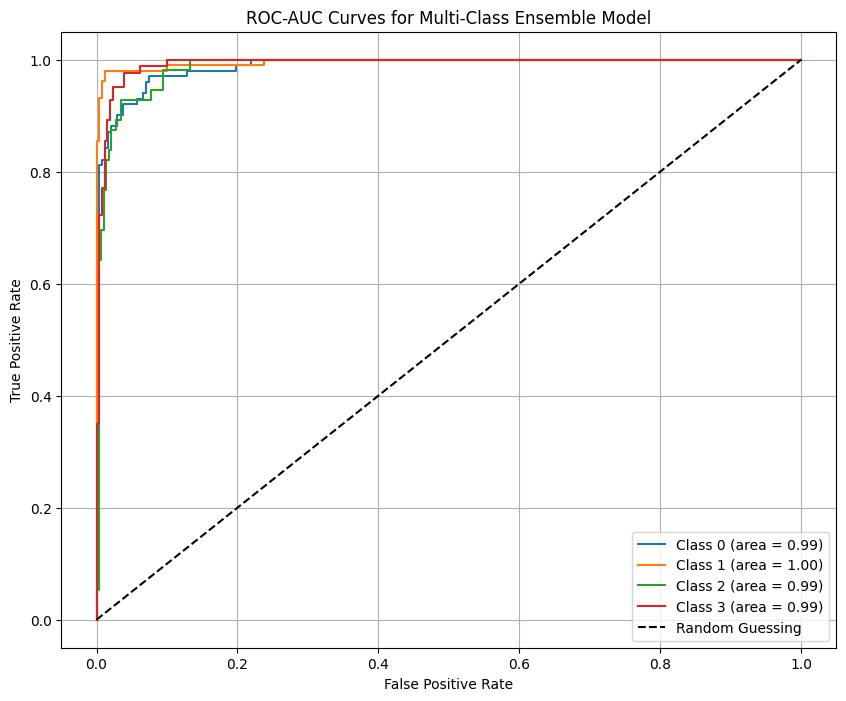

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y_test))
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

googlenet_probs = googlenet_model.predict(x_test)
resnet_probs = resnet_model.predict(x_test)

ensemble_probs = (googlenet_probs + resnet_probs) / 2

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], ensemble_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.title('ROC-AUC Curves for Multi-Class Ensemble Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


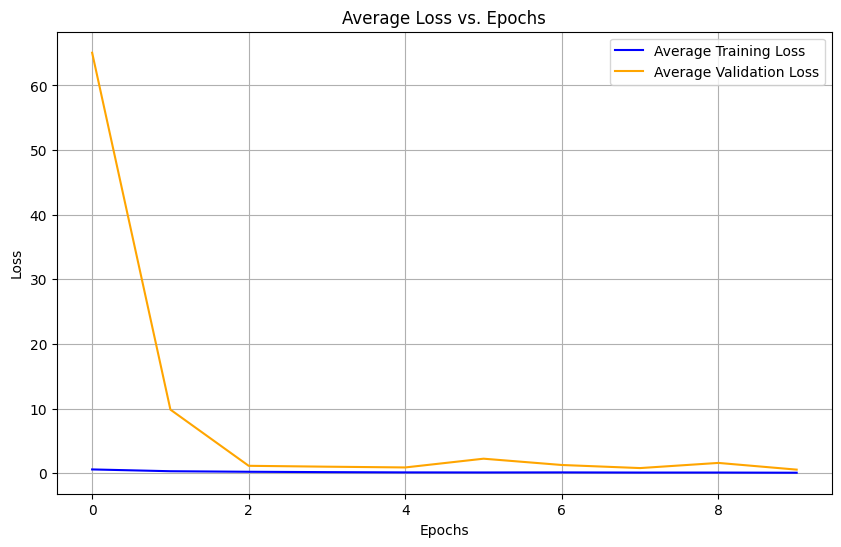

In [35]:
epochs = range(len(googlenet_history.history['loss']))

# Calculate the average training loss and validation loss
avg_train_loss = np.mean(
    [googlenet_history.history['loss'],
     resnet_history.history['loss']],
    axis=0)

avg_val_loss = np.mean(
    [googlenet_history.history['val_loss'],
     resnet_history.history['val_loss']],
    axis=0)

# Plotting the loss curves
plt.figure(figsize=(10, 6))

# Plot for Training Loss (averaged)
plt.plot(epochs, avg_train_loss, label='Average Training Loss', color='blue')

# Plot for Validation Loss (averaged)
plt.plot(epochs, avg_val_loss, label='Average Validation Loss', color='orange')

plt.title('Average Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
